In [3]:
# install ktrain on Google Colab
!pip3 install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.39.0-py3-none-any.whl size=25319738 sha256=37192f91994fd8e219c30078befd09187b4b7756bcd9c0be99e0b9c95d770491
  Stored in directory: /root/.cache/pip/wheels/98/fd/0a/ef6252223f3d2

In [4]:
import pandas as pd
import numpy as np

import ktrain
from ktrain import text

import urllib.request
import zipfile
import os


import time

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [6]:
def Plot(hist,model):
  plt.subplot(1, 2, 1)
  plt.plot(hist['accuracy'])
  plt.plot(hist['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(hist['loss'])
  plt.plot(hist['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.savefig(f'{model}_TrainingPlot.png')
  plt.show()



In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax





## Import Data

In [4]:
data_train = pd.read_csv('data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data_test.csv', encoding='utf-8')

X_train = data_train.Text.tolist()
X_test = data_test.Text.tolist()

y_train = data_train.Emotion.tolist()
y_test = data_test.Emotion.tolist()

data = pd.concat([data_train, data_test], ignore_index=True)


class_names = ['joy', 'sadness', 'fear', 'anger', 'neutral']

print('size of training set: %s' % (len(data_train['Text'])))
print('size of validation set: %s' % (len(data_test['Text'])))
print(data.Emotion.value_counts())

data.head(10)

size of training set: 7934
size of validation set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


In [5]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}

# Integer values for each class
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

## Data preprocessing


In [6]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350,
                                                                       max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


##  Training and validation


Loading the pretrained BERT for text classification

In [7]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


Wrap it in a Learner object

In [8]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=12)

Train the model. More about tuning learning rates [here](https://github.com/amaiya/ktrain/blob/master/tutorial-02-tuning-learning-rates.ipynb)

In [10]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
662/662 [==============================] - 758s 1s/step - loss: 1.0101 - accuracy: 0.6134 - val_loss: 0.5908 - val_accuracy: 0.7949
Epoch 2/3
662/662 [==============================] - 783s 1s/step - loss: 0.4705 - accuracy: 0.8402 - val_loss: 0.5266 - val_accuracy: 0.8190
Epoch 3/3
662/662 [==============================] - 783s 1s/step - loss: 0.2229 - accuracy: 0.9337 - val_loss: 0.5538 - val_accuracy: 0.8299


Validation

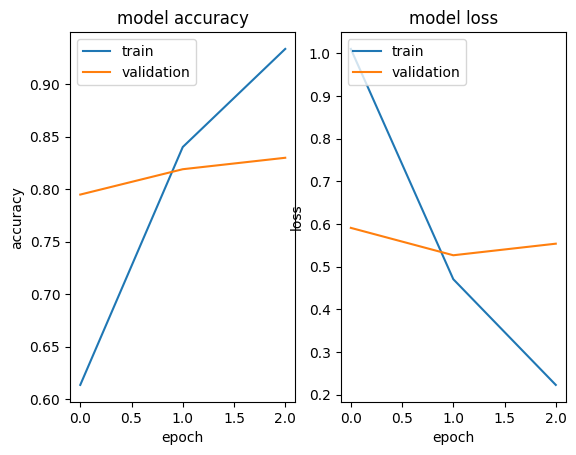

In [11]:
history = learner.history
Plot(history.history,"BertMod")

In [12]:
results=learner.validate(val_data=(x_test, y_test), class_names=class_names)

107/107 [==============================] - 96s 865ms/step
              precision    recall  f1-score   support

         joy       0.85      0.85      0.85       707
     sadness       0.82      0.81      0.81       676
        fear       0.87      0.85      0.86       679
       anger       0.79      0.81      0.80       693
     neutral       0.81      0.83      0.82       638

    accuracy                           0.83      3393
   macro avg       0.83      0.83      0.83      3393
weighted avg       0.83      0.83      0.83      3393



In [35]:
bertPredictor=ktrain.load_predictor("/content/drive/MyDrive/NLPProject/Bert")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [36]:
y_pred = bertPredictor.predict(X_test)

In [37]:
y_pred[1:5]

['anger', 'anger', 'fear', 'sadness']

In [38]:
report = classification_report(data_test.Emotion, y_pred)

In [39]:
print(report)

              precision    recall  f1-score   support

       anger       0.79      0.81      0.80       693
        fear       0.87      0.85      0.86       679
         joy       0.85      0.85      0.85       707
     neutral       0.81      0.83      0.82       638
     sadness       0.82      0.81      0.81       676

    accuracy                           0.83      3393
   macro avg       0.83      0.83      0.83      3393
weighted avg       0.83      0.83      0.83      3393



In [15]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['joy', 'sadness', 'fear', 'anger', 'neutral']

In [ ]:

message = 'I don\'t know what\'s going on with my girl friend'

start_time = time.time()
prediction = predictor.predict(message)

print('predicted: {} ({:.2f})'.format(prediction, (time.time() - start_time)))

predicted: sadness (0.11)


In [30]:
y_pred = predictor.predict(X_test)

In [31]:
y_pred[1:5]

['anger', 'anger', 'fear', 'sadness']

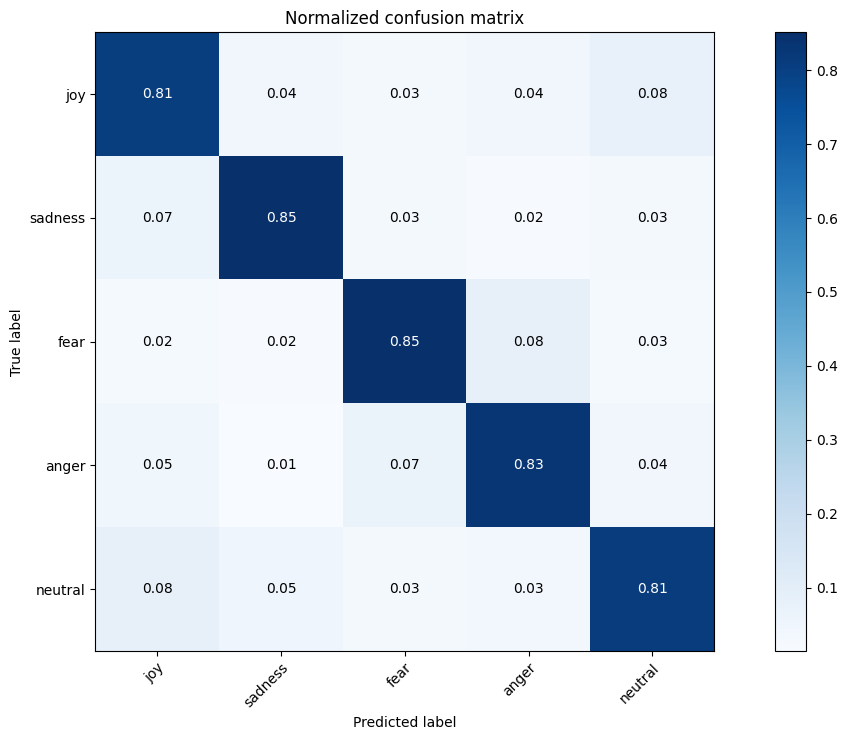

In [40]:
plot_confusion_matrix(data_test.Emotion, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.savefig('BERTModelModConfusionMatrix.png')
plt.show()

## Saving Bert model


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!cp -r "/content/bert_model" "/content/drive/My Drive/NLPProject"

In [16]:
# let's save the predictor for later use
predictor.save("bert_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done! to reload the predictor use: ktrain.load_predictor

## LSTM Model

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [ ]:
data = pd.concat([data_train, data_test], ignore_index=True)


In [ ]:
def clean_text(data):

    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sundeeprn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix



fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')


embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape



Unzipping...
done.


(12088, 300)

In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


In [ ]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
gru_output_size = 128
bidirectional = True

LSTM_model = Sequential()
LSTM_model.add(embedd_layer)

if bidirectional:
    LSTM_model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     LSTM_model.add(GRU(units=gru_output_size,
                dropout=0.2,
                recurrent_dropout=0.2))

LSTM_model.add(Dense(num_classes, activation='softmax'))
LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 bidirectional (Bidirection  (None, 256)               330240    
 al)                                                             
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 3957925 (15.10 MB)
Trainable params: 331525 (1.26 MB)
Non-trainable params: 3626400 (13.83 MB)
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 20

hist = LSTM_model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/20
62/62 [==============================] - 178s 3s/step - loss: 1.4101 - accuracy: 0.3963 - val_loss: 1.2727 - val_accuracy: 0.4901
Epoch 2/20
62/62 [==============================] - 196s 3s/step - loss: 1.0973 - accuracy: 0.5752 - val_loss: 0.9580 - val_accuracy: 0.6437
Epoch 3/20
62/62 [==============================] - 519s 8s/step - loss: 0.8650 - accuracy: 0.6829 - val_loss: 0.8583 - val_accuracy: 0.6817
Epoch 4/20
62/62 [==============================] - 219s 4s/step - loss: 0.7876 - accuracy: 0.7119 - val_loss: 0.8098 - val_accuracy: 0.7076
Epoch 5/20
62/62 [==============================] - 244s 4s/step - loss: 0.7440 - accuracy: 0.7293 - val_loss: 0.7813 - val_accuracy: 0.7194
Epoch 6/20
62/62 [==============================] - 245s 4s/step - loss: 0.7071 - accuracy: 0.7440 - val_loss: 0.7736 - val_accuracy: 0.7247
Epoch 7/20
62/62 [==============================] - 239s 4s/step - loss: 0.6932 - accuracy: 0.7493 - val_loss: 0.7662 - val_accuracy: 0.7274
Epoch 8/20
62

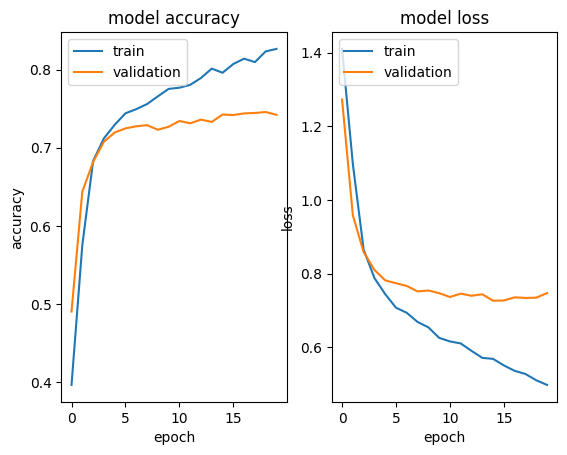

In [ ]:
Plot(hist.history,"LSTM")

In [ ]:
LSTM_model.save('LSTM.h5')

/Users/sundeeprn/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp -r "/content/LSTMModelTrainingPlot.png" "/content/drive/My Drive/NLPProject"

In [ ]:

predictions = LSTM_model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))
print("classification report")
report = classification_report(data_test.Emotion, predictions)




107/107 [==============================] - 28s 266ms/step
Accuracy: 74.21%

F1 Score: 74.21
classification report


In [ ]:
print(report)

              precision    recall  f1-score   support

       anger       0.75      0.66      0.70       693
        fear       0.72      0.81      0.76       679
         joy       0.74      0.77      0.75       707
     neutral       0.74      0.80      0.77       638
     sadness       0.77      0.67      0.72       676

    accuracy                           0.74      3393
   macro avg       0.74      0.74      0.74      3393
weighted avg       0.74      0.74      0.74      3393



In [ ]:
!cp -r "/content/LSTM_ConfusionMatrix.png" "/content/drive/My Drive/NLPProject"

In [ ]:
import time

message = ['I don\'t know what\'s going on with my girl friend']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = LSTM_model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 93ms/step
Message: ["I don't know what's going on with my girl friend"]
predicted: sadness (0.12 seconds)


In [ ]:
model.save('/drive/My Drive/NLPProject/models/LSTM.h5')

## Roberta Model

In [6]:
RobertaModel = 'roberta-base'

model = text.Transformer(RobertaModel, maxlen=500, class_names=class_names)

trn = model.preprocess_train(X_train, y_train)
val = model.preprocess_test(X_test, y_test)

roberta_model = model.get_classifier()
BATCH_SIZE = 12
roberta_learner = ktrain.get_learner(roberta_model, train_data=trn, val_data=val, batch_size=BATCH_SIZE)
roberta_learner.fit_onecycle(2e-5, 3)



config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 17
	95percentile : 41
	99percentile : 61


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 40
	99percentile : 57




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
662/662 [==============================] - 990s 1s/step - loss: 0.9705 - accuracy: 0.6172 - val_loss: 0.5364 - val_accuracy: 0.8070
Epoch 2/3
662/662 [==============================] - 976s 1s/step - loss: 0.4842 - accuracy: 0.8370 - val_loss: 0.4933 - val_accuracy: 0.8403
Epoch 3/3
662/662 [==============================] - 963s 1s/step - loss: 0.3006 - accuracy: 0.9050 - val_loss: 0.4657 - val_accuracy: 0.8467


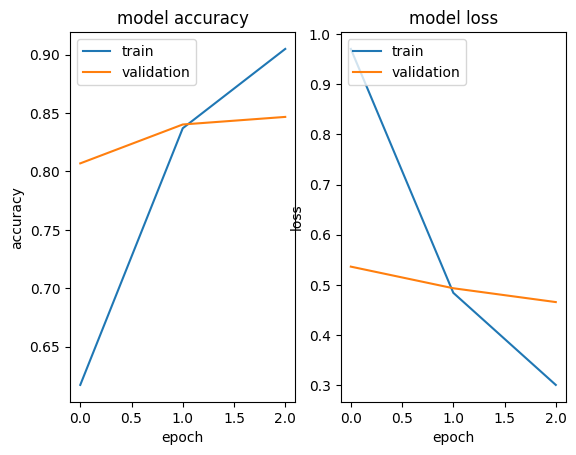

In [7]:
history=roberta_learner.history
Plot(history.history,"RobertaMod")

In [10]:
model = text.Transformer(RobertaModel, maxlen=500, class_names=class_names)
predictor = ktrain.get_predictor(roberta_learner.model, preproc = model)
y_pred = predictor.predict(X_test)

/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


In [11]:
y_pred[1:5]

['anger', 'anger', 'fear', 'anger']

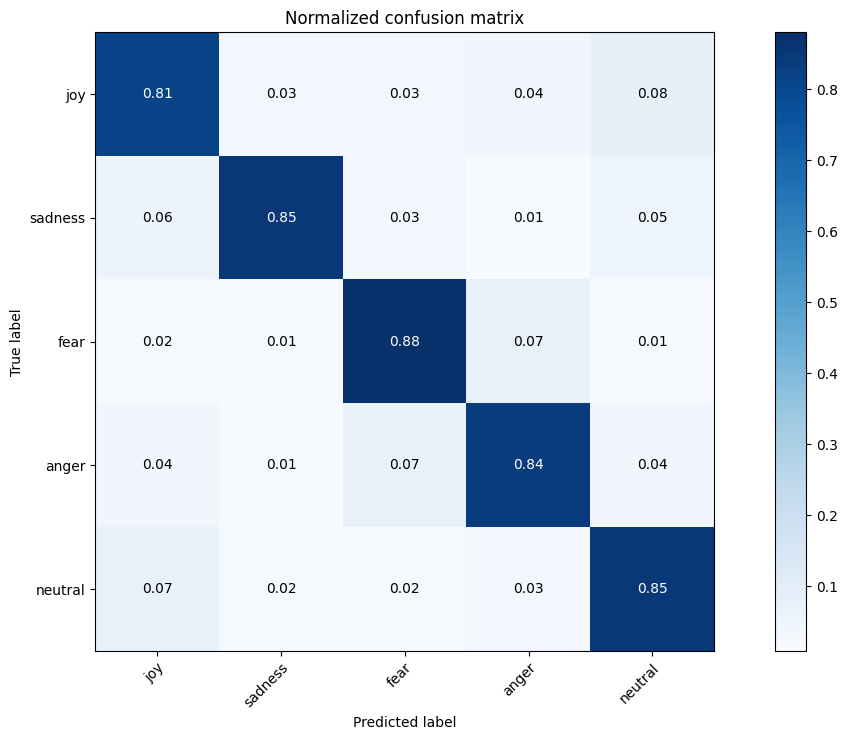

In [34]:
plot_confusion_matrix(data_test.Emotion, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.savefig('ROBERTAModelModConfusionMatrix.png')
plt.show()

In [15]:
predictor.save("Roberta_model_mod")

In [18]:
!cp -r "/content/Roberta_model_mod" "/content/drive/My Drive/NLPProject/RobertaMod"

In [21]:

msg = 'I don\'t know what\'s going on with my girl friend'
preprocess_train_called=True
st = time.time()
prediction = predictor.predict(msg)
et=time.time()
print('predicted: {} ({:.2f})'.format(prediction, (et - st)))

predicted: sadness (0.23)


In [32]:
report = classification_report(data_test.Emotion, y_pred)

In [33]:
print(report)

              precision    recall  f1-score   support

       anger       0.82      0.81      0.82       693
        fear       0.91      0.85      0.88       679
         joy       0.86      0.88      0.87       707
     neutral       0.83      0.84      0.83       638
     sadness       0.82      0.85      0.84       676

    accuracy                           0.85      3393
   macro avg       0.85      0.85      0.85      3393
weighted avg       0.85      0.85      0.85      3393

